In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pymysql
from sqlalchemy import create_engine
import getpass

In [2]:
password = getpass.getpass()

········


1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X)

In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'

engine = create_engine(connection_string)

query = ''' SELECT
    f.title, f.film_id, f.rental_duration, f.rental_rate, f.length, c.name, c.category_id FROM sakila.film as f
    JOIN
   sakila.film_category as fc ON f.film_id = fc.film_id
    JOIN
    sakila.category as c ON fc.category_id = c.category_id; '''

In [4]:
# data = X (prediction model)
data = pd.read_sql_query(query, engine)
data.head()

,title,film_id,rental_duration,rental_rate,length,name,category_id
0,AMADEUS HOLY,19,6,0.99,113,Action,1
1,AMERICAN CIRCUS,21,3,4.99,129,Action,1
2,ANTITRUST TOMATOES,29,5,2.99,168,Action,1
3,ARK RIDGEMONT,38,6,0.99,68,Action,1
4,BAREFOOT MANCHURIAN,56,6,2.99,129,Action,1


In [5]:
data.shape

(1000, 7)

2. Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.

In [6]:
from sqlalchemy.sql import func

In [7]:
# rented_in_may = Y (prediction model)

rented_in_may = '''SELECT f.title,
    MAX(CASE WHEN MONTH(r.rental_date) = 5 AND YEAR(r.rental_date) = 2005 THEN TRUE ELSE FALSE END) AS rented_in_may_2005
FROM
    sakila.film AS f
LEFT JOIN
    sakila.inventory AS i ON f.film_id = i.film_id
LEFT JOIN
    sakila.rental AS r ON i.inventory_id = r.inventory_id
GROUP BY
    f.title;
    '''

3. Read the data into a Pandas dataframe. At this point you should have 1000 rows. Number of columns depends on the number of features you chose.

In [8]:
rented_in_may = pd.read_sql_query(rented_in_may, engine)
rented_in_may.head()

,title,rented_in_may_2005
0,ACADEMY DINOSAUR,1
1,ACE GOLDFINGER,0
2,ADAPTATION HOLES,1
3,AFFAIR PREJUDICE,1
4,AFRICAN EGG,1


In [9]:
 rented_in_may.shape

(1000, 2)

In [10]:
r_in_may = rented_in_may['rented_in_may_2005'].value_counts()
r_in_may

1    686
0    314
Name: rented_in_may_2005, dtype: int64

4. Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            1000 non-null   object 
 1   film_id          1000 non-null   int64  
 2   rental_duration  1000 non-null   int64  
 3   rental_rate      1000 non-null   float64
 4   length           1000 non-null   int64  
 5   name             1000 non-null   object 
 6   category_id      1000 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 54.8+ KB


In [12]:
data.describe()

,film_id,rental_duration,rental_rate,length,category_id
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,500.500000,4.985000,2.980000,115.272000,8.47800
std,288.819436,1.411654,1.646393,40.426332,4.61029
min,1.000000,3.000000,0.990000,46.000000,1.00000
25%,250.750000,4.000000,0.990000,80.000000,5.00000
50%,500.500000,5.000000,2.990000,114.000000,8.00000
75%,750.250000,6.000000,4.990000,149.250000,13.00000
max,1000.000000,7.000000,4.990000,185.000000,16.00000


In [13]:
data.value_counts()

title             film_id  rental_duration  rental_rate  length  name         category_id
ACADEMY DINOSAUR  1        6                0.99         86      Documentary  6              1
PERFECT GROOVE    672      7                2.99         82      Comedy       5              1
PARK CITIZEN      659      3                4.99         109     Action       1              1
PARTY KNOCK       660      7                2.99         107     Comedy       5              1
PAST SUICIDES     661      5                4.99         157     Foreign      9              1
                                                                                            ..
FROGMEN BREAKING  339      5                0.99         111     Travel       16             1
FRONTIER CABIN    340      6                4.99         183     New          13             1
FROST HEAD        341      5                0.99         82      Classics     4              1
FUGITIVE MAGUIRE  342      7                4.99       

In [14]:
data.isna().sum()

title              0
film_id            0
rental_duration    0
rental_rate        0
length             0
name               0
category_id        0
dtype: int64

ValueError: x and y must be the same size

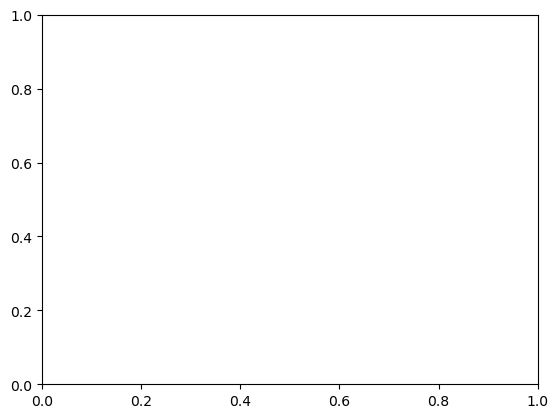

In [19]:
# I would like to visualize the data
# I don't get the error message "ValueError: x and y must be the same size"
# as 'data' and 'rented_in_may' are both 1000 rows long

import matplotlib.pyplot as plt

x = data[['rental_duration', 'film_id', 'rental_rate', 'length']]
y = rented_in_may['rented_in_may_2005']

plt.scatter(x, y)

x = data[['rental_duration', 'film_id', 'rental_rate', 'length']]
y = rented_in_may['rented_in_may_2005']

plt.scatter(x['rental_duration'], y, label='rental_duration')
plt.scatter(x['film_id'], y, label='film_id')
plt.scatter(x['rental_rate'], y, label='rental_rate')
plt.scatter(x['length'], y, label='length')


plt.xlabel('Data Features')
plt.ylabel('Rented in May')
plt.title('Visualize Data')



plt.show()

In [22]:
# I have no idea if it's a good idea :
# encoding the categorical column "title"

encoder = OneHotEncoder()
encoder.fit_transform(data[['title']]).toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
#scaling numerical variables
#step 1: select numerical columns 
#Anyway I am not going to use it because I don't want it to create a problem ;)

df = pd.DataFrame(data)

numerical_columns = ['rental_duration', 'film_id', 'rental_rate', 'length']

numerical_columns_df = df[numerical_columns]

display(numerical_columns_df)


,rental_duration,film_id,rental_rate,length
0,6,19,0.99,113
1,3,21,4.99,129
2,5,29,2.99,168
3,6,38,0.99,68
4,6,56,2.99,129
...,...,...,...,...
995,7,931,0.99,48
996,3,977,2.99,85
997,7,981,0.99,55
998,7,988,2.99,139


In [23]:
#scaling numerical variables
#step 2: select numerical columns 

from sklearn.preprocessing import StandardScaler

columns_to_scale = ['film_id', 'rental_duration', 'rental_rate', 'length']

scaler = StandardScaler()

numerical_columns_df[columns_to_scale] = scaler.fit_transform(numerical_columns_df[columns_to_scale])


/var/folders/jj/7c0z5mzs4y128nfwqptlsf000000gn/T/ipykernel_5804/4027343317.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_columns_df[columns_to_scale] = scaler.fit_transform(numerical_columns_df[columns_to_scale])


In [24]:
print(numerical_columns_df[columns_to_scale].describe())

            film_id  rental_duration   rental_rate        length
count  1.000000e+03     1.000000e+03  1.000000e+03  1.000000e+03
mean   7.105427e-18    -2.504663e-16 -3.836931e-16 -1.421085e-16
std    1.000500e+00     1.000500e+00  1.000500e+00  1.000500e+00
min   -1.730320e+00    -1.406855e+00 -1.209308e+00 -1.714394e+00
25%   -8.651598e-01    -6.981121e-01 -1.209308e+00 -8.729372e-01
50%    0.000000e+00     1.063115e-02  6.076922e-03 -3.148038e-02
75%    8.651598e-01     7.193744e-01  1.221461e+00  8.409124e-01
max    1.730320e+00     1.428118e+00  1.221461e+00  1.725679e+00


5. Create a logistic regression model to predict 'rented_in_may' from the cleaned data.

In [25]:
# Split the data into train and test sets

X = numerical_columns_df
y = rented_in_may['rented_in_may_2005']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Our model : Logistic Regression

model = LogisticRegression()

In [27]:
#train the model

model.fit(X_train, y_train)

LogisticRegression()

6.Evaluate the results.

In [28]:
# Use the model

y_pred = model.predict(X_test)

In [29]:
# Calculate precision

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.675


In [30]:
# Calculate confusion matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[  0  65]
 [  0 135]]


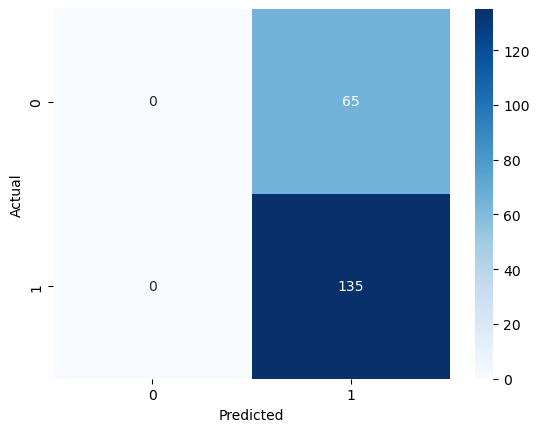

In [31]:
# Visualize the result

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The model predicted 135 occurrences of the positive class (1). 
But we can see there are 65 false predictions where the model predicted the positive class when it was actually the negative class.
The accuracy is 67 %, which not fantastic. 
This is not a great model.